# Model to classify 30 tree species based on LeafSnap data subset

### Settings

In [1]:
# Imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
from numpy import load
import os.path
import matplotlib.pyplot as plt
import pandas as pd

import keras.backend as K
if(K.tensorflow_backend):
    import tensorflow as tf
    tf.logging.set_verbosity(tf.logging.ERROR)
from keras.utils import np_utils
from keras.models import load_model

from code import data as d
from code import model as m

Using TensorFlow backend.


### Load the data and split into train, test and validation

In [2]:
original_data_path = "/home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/"
images_fname = os.path.join(original_data_path, "images.npz")
labels_fname = os.path.join(original_data_path, "labels.npz")
info_fname_rand = os.path.join(original_data_path, "leafsnap-dataset-30subset-images-enhanced-randomized.txt")

# load data
image_data = np.load(images_fname)
labels_data = np.load(labels_fname)
info_data = pd.read_csv(info_fname_rand)

images = image_data['images']
labels_one_hot = labels_data['labels_one_hot']


print('Image size: ', np.shape(images))
print('Labels one hot size: ', np.shape(labels_one_hot))

nim = len(labels_one_hot)
print('Number of images: ', nim)

info_data.tail()

Image size:  (6136, 64, 64, 3)
Labels one hot size:  (6136, 30)
Number of images:  6136


,filename,label,source,label_numeric,path
6131,pi0057-05-1.jpg,Tilia americana,lab,15,dataset/images/lab/Auto_cropped/tilia_american...
6132,wb1194-05-2.jpg,Betula lenta,lab,3,dataset/images/lab/Auto_cropped/betula_lenta/w...
6133,pi0005-05-3.jpg,Ptelea trifoliata,lab,25,dataset/images/lab/Auto_cropped/ptelea_trifoli...
6134,ny1124-02-2.jpg,Broussonettia papyrifera,lab,23,dataset/images/lab/Auto_cropped/broussonettia_...
6135,1249580214_0004.jpg,Magnolia grandiflora,field,8,dataset/images/field/magnolia_grandiflora/1249...


### Split the data into train, test and validation

In [3]:
[images_train, images_val, images_test, 
 labels_one_hot_train, labels_one_hot_val, labels_one_hot_test,
 end_train_ind, end_val_ind] = d.split_data(images,labels_one_hot)
print('Image size - train set: ', np.shape(images_train))
print('Labels size - train set: ', np.shape(labels_one_hot_train)) 
print('Image size - valid. set: ', np.shape(images_val))
print('Labels size - valid. set: ', np.shape(labels_one_hot_val)) 
print('Image size - test set: ', np.shape(images_test))
print('Labels size - test set: ', np.shape(labels_one_hot_test)) 

print('Indicies: ', end_train_ind,', ', end_val_ind)
    

Image size - train set:  (4295, 64, 64, 3)
Labels size - train set:  (4295, 30)
Image size - valid. set:  (1227, 64, 64, 3)
Labels size - valid. set:  (1227, 30)
Image size - test set:  (614, 64, 64, 3)
Labels size - test set:  (614, 30)
Indicies:  4295 ,  5522


In [4]:
# splitting some of of the info data

labels_train = info_data.loc[:end_train_ind, "label"]
sources_train = info_data.loc[:end_train_ind, "source"]

labels_numeric_test = info_data.loc[end_val_ind:nim, "label_numeric"]
labels_test = info_data.loc[end_val_ind:nim, "label"]
filenames_test = info_data.loc[end_val_ind:nim, "filename"]
sources_test = info_data.loc[end_val_ind:nim, "source"]
path_test = info_data.loc[end_val_ind:nim, "path"]

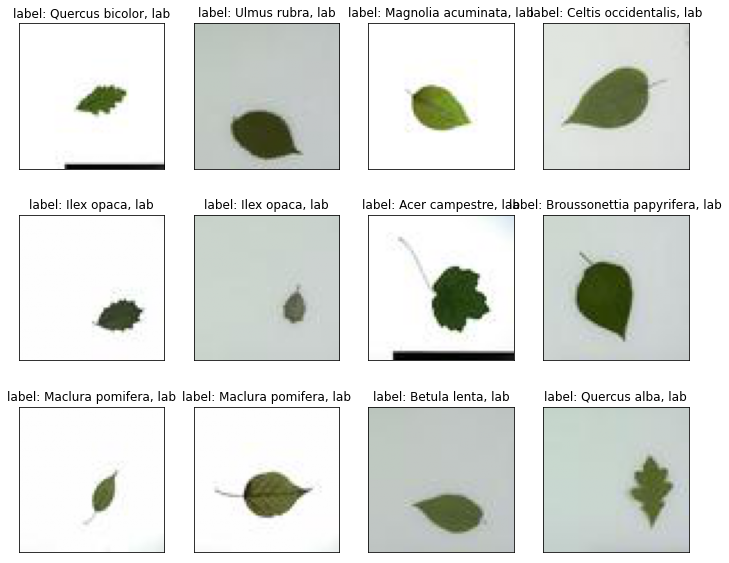

In [5]:
# plot random train images
d.plot_12images(images = images_train, labels = labels_train, sources = sources_train, figsize=(12,10))

### Data formatting

In [6]:
img_rows = 64
img_cols = 64
img_channels = 3
#print(K.image_data_format())
if K.image_data_format() == 'channels_first':
    images_train = images_train.reshape(images_train.shape[0], img_channels, img_rows, img_cols)
    images_test = images_test.reshape(images_test.shape[0], img_channels, img_rows, img_cols)
    images_val = images_val.reshape(images_val.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    images_train = images_train.reshape(images_train.shape[0], img_rows, img_cols, img_channels)
    images_test = images_test.reshape(images_test.shape[0], img_rows, img_cols, img_channels)
    images_val = images_val.reshape(images_val.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)
print("Size of training data: ", np.shape(images_train))
print("Size of validation data: ", np.shape(images_val))
print("Size of testing data: ", np.shape(images_test))

Size of training data:  (4295, 64, 64, 3)
Size of validation data:  (1227, 64, 64, 3)
Size of testing data:  (614, 64, 64, 3)


## Construct the model

In [7]:
model = m.generate_simpler_model(input_shape, 30)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_layer1 (Conv2D)       (None, 60, 60, 12)        912       
_________________________________________________________________
maxpooling2d_layer1 (MaxPool (None, 30, 30, 12)        0         
_________________________________________________________________
conv2d_layer2 (Conv2D)       (None, 26, 26, 24)        7224      
_________________________________________________________________
maxpooling2d_layer2 (MaxPool (None, 13, 13, 24)        0         
_________________________________________________________________
dropout_layer1 (Dropout)     (None, 13, 13, 24)        0         
_________________________________________________________________
flatten_layer1 (Flatten)     (None, 4056)              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 200)               811400    
__________

### Train the model

In [8]:
from keras.callbacks import ModelCheckpoint

# autosave best Model
best_model_file = model_fname = os.path.join(original_data_path, 'Models','leafnet.h5')
best_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
batch_size = 64
epochs = 400
model, results = m.train_model(model, images_train, labels_one_hot_train,
                             images_val, labels_one_hot_val, 
                             batch_size, epochs, best_model)
print('Traing finished.')

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')


Training model...
Train on 4295 samples, validate on 1227 samples
Epoch 1/400
4295/4295 [==============================] - 20s 5ms/step - loss: 3.3860 - acc: 0.0624 - val_loss: 3.3192 - val_acc: 0.1027

Epoch 00001: val_loss improved from inf to 3.31924, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 2/400
4295/4295 [==============================] - 17s 4ms/step - loss: 3.2818 - acc: 0.1069 - val_loss: 3.1317 - val_acc: 0.1483

Epoch 00002: val_loss improved from 3.31924 to 3.13172, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 3/400
4295/4295 [==============================] - 17s 4ms/step - loss: 3.1081 - acc: 0.1418 - val_loss: 2.9080 - val_acc: 0.1972

Epoch 00003: val_loss improved from 3.13172 to 2.90805, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 4/400
4295/4295 [==============================] - 20s 5ms/step -

4295/4295 [==============================] - 15s 3ms/step - loss: 1.8942 - acc: 0.4228 - val_loss: 1.7239 - val_acc: 0.4980

Epoch 00031: val_loss improved from 1.74803 to 1.72394, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 32/400
4295/4295 [==============================] - 14s 3ms/step - loss: 1.8612 - acc: 0.4405 - val_loss: 1.7152 - val_acc: 0.4931

Epoch 00032: val_loss improved from 1.72394 to 1.71524, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 33/400
4295/4295 [==============================] - 18s 4ms/step - loss: 1.8250 - acc: 0.4612 - val_loss: 1.6730 - val_acc: 0.5045

Epoch 00033: val_loss improved from 1.71524 to 1.67298, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 34/400
4295/4295 [==============================] - 16s 4ms/step - loss: 1.8049 - acc: 0.4624 - val_loss: 1.6562 - val_acc: 0.5053

Epoch

4295/4295 [==============================] - 15s 4ms/step - loss: 1.1662 - acc: 0.6226 - val_loss: 1.1180 - val_acc: 0.6569

Epoch 00100: val_loss improved from 1.14338 to 1.11799, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 101/400
4295/4295 [==============================] - 16s 4ms/step - loss: 1.1364 - acc: 0.6368 - val_loss: 1.0936 - val_acc: 0.6601

Epoch 00101: val_loss improved from 1.11799 to 1.09359, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 102/400
4295/4295 [==============================] - 14s 3ms/step - loss: 1.1218 - acc: 0.6356 - val_loss: 1.1302 - val_acc: 0.6414

Epoch 00102: val_loss did not improve from 1.09359
Epoch 103/400
4295/4295 [==============================] - 13s 3ms/step - loss: 1.1633 - acc: 0.6307 - val_loss: 1.1379 - val_acc: 0.6414

Epoch 00103: val_loss did not improve from 1.09359
Epoch 104/400
4295/4295 [===========================

4295/4295 [==============================] - 12s 3ms/step - loss: 0.8543 - acc: 0.7192 - val_loss: 0.9724 - val_acc: 0.7009

Epoch 00177: val_loss did not improve from 0.93569
Epoch 178/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.8751 - acc: 0.7083 - val_loss: 0.9328 - val_acc: 0.7066

Epoch 00178: val_loss improved from 0.93569 to 0.93280, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 179/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.8488 - acc: 0.7183 - val_loss: 0.9330 - val_acc: 0.7009

Epoch 00179: val_loss did not improve from 0.93280
Epoch 180/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.8392 - acc: 0.7199 - val_loss: 0.9196 - val_acc: 0.7082

Epoch 00180: val_loss improved from 0.93280 to 0.91958, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 181/400
4295/4295 [===========================

4295/4295 [==============================] - 12s 3ms/step - loss: 0.7693 - acc: 0.7350 - val_loss: 0.9224 - val_acc: 0.6968

Epoch 00217: val_loss did not improve from 0.89500
Epoch 218/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.8156 - acc: 0.7201 - val_loss: 0.9322 - val_acc: 0.7180

Epoch 00218: val_loss did not improve from 0.89500
Epoch 219/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.7821 - acc: 0.7367 - val_loss: 0.8926 - val_acc: 0.7213

Epoch 00219: val_loss improved from 0.89500 to 0.89263, saving model to /home/elena/eStep/XAI/Data/LeafSnap/leafsnap-dataset-30subset/Models/leafnet.h5
Epoch 220/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.7562 - acc: 0.7467 - val_loss: 0.9066 - val_acc: 0.7245

Epoch 00220: val_loss did not improve from 0.89263
Epoch 221/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.7904 - acc: 0.7376 - val_loss: 0.9030 - val_acc: 0.7286

Epoch 00221: v

4295/4295 [==============================] - 14s 3ms/step - loss: 0.6411 - acc: 0.7811 - val_loss: 0.9048 - val_acc: 0.7213

Epoch 00295: val_loss did not improve from 0.82131
Epoch 296/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.7253 - acc: 0.7541 - val_loss: 0.8789 - val_acc: 0.7245

Epoch 00296: val_loss did not improve from 0.82131
Epoch 297/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.6683 - acc: 0.7823 - val_loss: 0.8368 - val_acc: 0.7400

Epoch 00297: val_loss did not improve from 0.82131
Epoch 298/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.6517 - acc: 0.7809 - val_loss: 0.9017 - val_acc: 0.7156

Epoch 00298: val_loss did not improve from 0.82131
Epoch 299/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.6515 - acc: 0.7837 - val_loss: 0.8364 - val_acc: 0.7359

Epoch 00299: val_loss did not improve from 0.82131
Epoch 300/400
4295/4295 [==============================] - 12s 3


Epoch 00377: val_loss did not improve from 0.78318
Epoch 378/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.6043 - acc: 0.7981 - val_loss: 0.8186 - val_acc: 0.7514

Epoch 00378: val_loss did not improve from 0.78318
Epoch 379/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.5717 - acc: 0.8095 - val_loss: 0.7864 - val_acc: 0.7628

Epoch 00379: val_loss did not improve from 0.78318
Epoch 380/400
4295/4295 [==============================] - 12s 3ms/step - loss: 0.5770 - acc: 0.7998 - val_loss: 0.8401 - val_acc: 0.7343

Epoch 00380: val_loss did not improve from 0.78318
Epoch 381/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.5783 - acc: 0.8065 - val_loss: 0.8055 - val_acc: 0.7522

Epoch 00381: val_loss did not improve from 0.78318
Epoch 382/400
4295/4295 [==============================] - 13s 3ms/step - loss: 0.5840 - acc: 0.7979 - val_loss: 0.8329 - val_acc: 0.7368

Epoch 00382: val_loss did not improve from 0.7831

### Test the model

In [9]:
score = model.evaluate(images_test, labels_one_hot_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8515865476589638
Test accuracy: 0.7491856679465949


### Examine training process

In [10]:
print(results)

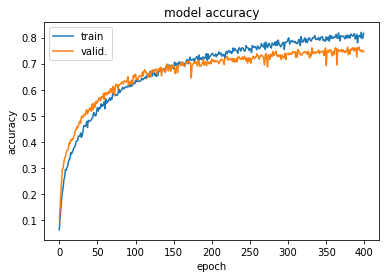

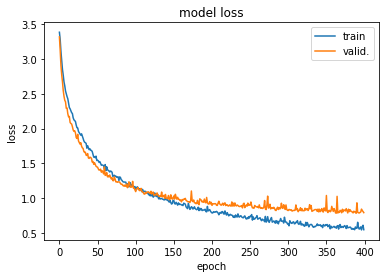

In [11]:
from matplotlib import pyplot as plt

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid.'], loc='upper right')
plt.show()